По материалам 16 семинара провести исследование по тематическому моделированию и разработать рекомендательную систему.

1. рекомендательная система обучается на корпусе текстов, в качестве корпуса текстов использовать 20 news groups из scikit-learn
2. пользователь предъявляет образец текста (не обязательно из обучающего корпуса) и просит показать k похожих по тематике текстов
3. в качестве моделей для тематического моделирования рассмотреть NMF, LSA, LDA
4. в качестве метрик topic coherence рассмотреть TC-W2C, UCI, Umass для топ-20 слов-дескрипторов тем
5. для каждой тематической модели определить оптимальное кол-во тем, а затем сравнить сами модели с помощью метрик topic coherence
6. при выборе оптимального кол-ва тем постройте проверяйте дескрипторы тем
7. таким образом, для каждой метрики вы получите свою оптимальную модель. Сравните дескрипторы тем у этих моделей, и выберите
8. таким образом, вы получите тематическое представление для каждого документа. Выберите функцию расстояния между документами, посмотрите sklearn.metrics
9. при поиске ближайших соседей используйте sklearn.neighbors
10. работу оформить в виде ноутбука *.ipynb
11. продемонстрируйте работу вашей рекомендательной системы на текстах из обучающего корпуса и текстах из bbc news за 2017 год


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

In [10]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

## Preprocess data

In [11]:
newsgroups = fetch_20newsgroups()
data = newsgroups.data

In [12]:
raw_documents = []
snippets = []
for line in data:
    text = line.strip()
    raw_documents.append( text.lower() )
    snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 11314 raw text documents


In [13]:
# custom stopwords
custom_stop_words = []
with open( "stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [14]:
# create BoW + tf-idf model
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names()
#joblib.dump((A,terms,snippets), "articles-tfidf.pkl")

Created 11314 X 8889 TF-IDF-normalized document-term matrix


/home/katya/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [15]:
# top features from tf-idf model
import operator


sums = np.array(A.sum(axis=0)).ravel()
# map weights to the terms
weights = { term: sums[col] for col, term in enumerate(terms)}
ranking = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
for i, pair in enumerate( ranking[0:20] ):
    print( "%s (%.2f)" % ( pair[0], pair[1] ) )

edu (476.15)
com (343.46)
subject (213.89)
lines (212.11)
organization (209.69)
writes (193.92)
article (191.88)
university (183.79)
posting (167.86)
host (160.93)
nntp (159.33)
ca (151.82)
know (151.48)
people (150.03)
get (143.27)
cs (131.41)
think (131.30)
good (120.71)
time (114.49)
distribution (113.65)


In [16]:
import re
import gensim


class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator( raw_documents, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
#w2v_model.save("w2v-model.bin")

Model has 12267 terms


## NMF, LSA, LDA

In [17]:
#(A,terms,snippets) = joblib.load( "articles-tfidf.pkl")

kmin, kmax = 4, 15

topic_models_NMF = []
for k in tqdm(range(kmin,kmax+1)):
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models_NMF.append( (k,W,H) )
    
topic_models_LSA = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models_LSA.append( (k,W,H) )
    
topic_models_LDA = []
for k in tqdm(range(kmin,kmax+1)):
    model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
    W = model.fit_transform( A )
    H = model.components_    
    topic_models_LDA.append( (k,W,H) )

100%|██████████| 12/12 [04:15<00:00, 21.27s/it]


In [18]:
from itertools import combinations


def calculate_coherence_tc_w2c( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)    

def calculate_tc_w2c(topic_models, w2v_model):
    k_values = []
    coherences = []
    for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence_tc_w2c( w2v_model, term_rankings ) )
        #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    return k_values, coherences


k_values_nmf_tc_w2c, coherences_nmf_tc_w2c = calculate_tc_w2c(topic_models_NMF, w2v_model)
k_values_lsa_tc_w2c, coherences_lsa_tc_w2c = calculate_tc_w2c(topic_models_LSA, w2v_model)
k_values_lda_tc_w2c, coherences_lda_tc_w2c = calculate_tc_w2c(topic_models_LDA, w2v_model)

In [19]:
def plot_coherences(k1, k2, k3, c1, c2, c3):
    fig = plt.figure(figsize=(13,7))
    # create the line plot
    plt.plot( k1, c1, 'r', label = 'NMF' )
    plt.plot( k2, c2, 'b', label = 'LSA' )
    plt.plot( k3, c3, 'g', label = 'LDA' )
    plt.xticks(k1)
    plt.xticks(k2)
    plt.xticks(k3)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    # add the points
    plt.scatter( k1, c1, s=50, color ='r')
    plt.scatter( k2, c2, s=50, color ='b')
    plt.scatter( k3, c3, s=50, color ='g')
    # find and annotate the maximum point on the plot
    ymax = max(c1)
    ymax2 = max(c2)
    ymax3 = max(c3)
    xpos1 = c1.index(ymax)
    xpos2 = c2.index(ymax2)
    xpos3 = c3.index(ymax3)
    best_k1 = k1[xpos1]
    best_k2 = k2[xpos2]
    best_k3 = k3[xpos3]
    plt.annotate( "k=%d" % best_k1, xy=(best_k1, ymax), xytext=(best_k1, ymax), textcoords="offset points", fontsize=16)
    plt.annotate( "k=%d" % best_k2, xy=(best_k2, ymax2), xytext=(best_k2, ymax2), textcoords="offset points", fontsize=16)
    plt.annotate( "k=%d" % best_k3, xy=(best_k3, ymax3), xytext=(best_k3, ymax3), textcoords="offset points", fontsize=16)
    plt.legend()
    plt.grid()
    # show the plot
    plt.show()

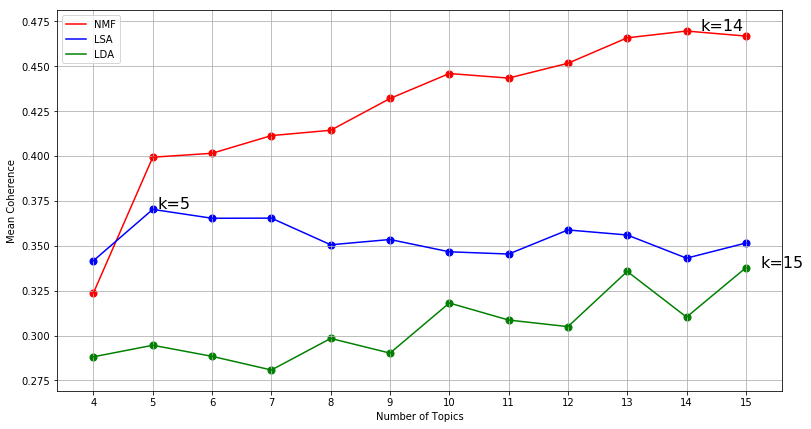

In [20]:
plot_coherences(k_values_nmf_tc_w2c, k_values_lsa_tc_w2c, k_values_lda_tc_w2c,
                coherences_nmf_tc_w2c, coherences_lsa_tc_w2c, coherences_lda_tc_w2c)

In [21]:
from collections import defaultdict

def reversed_index(docs):
    reverse = defaultdict(set)
    for i,doc in enumerate(docs):
        for token in doc:
            reverse[token].add(i)
    return reverse, i+1

In [22]:
index, all_docs = reversed_index(docgen)

In [23]:
def calculate_coherence_uci(index, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            bi_prob = len(index[pair[0]] & index[pair[1]]) / all_docs
            first_prob = len(index[pair[0]]) / all_docs
            second_prob = len(index[pair[1]]) / all_docs
            score = np.log((bi_prob + pow(10,-12)) / (first_prob * second_prob)) 
                                      # small constant to avoid bi_prob = 0
            pair_scores.append(score)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) * (2 / (len(term_rankings[topic_index]) * (len(term_rankings[topic_index])-1)))
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def calculate_uci(topic_models, index):
    k_values = []
    coherences = []
    for (k,W,H) in topic_models:
        # Get all of the topic descriptors - the term_rankings, based on top 20 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence_uci(index, term_rankings) )
        #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    return k_values, coherences


k_values_nmf_uci, coherences_nmf_uci = calculate_uci(topic_models_NMF, index)
k_values_lsa_uci, coherences_lsa_uci = calculate_uci(topic_models_LSA, index)
k_values_lda_uci, coherences_lda_uci = calculate_uci(topic_models_LDA, index)

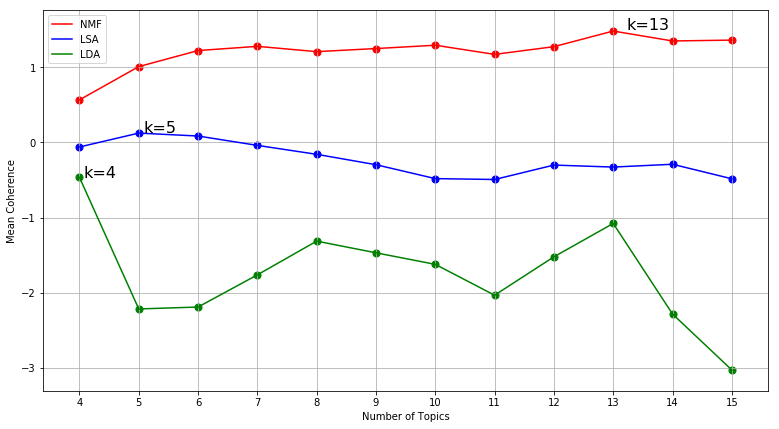

In [24]:
plot_coherences(k_values_nmf_uci, k_values_lsa_uci, k_values_lda_uci,
                coherences_nmf_uci, coherences_lsa_uci, coherences_lda_uci)

In [25]:
def calculate_coherence_umass(index, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            bi_prob = len(index[pair[0]] & index[pair[1]]) / all_docs
            first_prob = len(index[pair[0]]) / all_docs
            second_prob = len(index[pair[1]]) / all_docs
            score = np.log((bi_prob + pow(10,-12)) / first_prob) 
                                      # small constant to avoid bi_prob = 0
            pair_scores.append(score)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) * (2 / (len(term_rankings[topic_index]) * (len(term_rankings[topic_index])-1)))
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def calculate_umass(topic_models, index):
    k_values = []
    coherences = []
    for (k,W,H) in topic_models:
        # Get all of the topic descriptors - the term_rankings, based on top 20 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence_umass(index, term_rankings) )
        #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    return k_values, coherences


k_values_nmf_umass, coherences_nmf_umass = calculate_umass(topic_models_NMF, index)
k_values_lsa_umass, coherences_lsa_umass = calculate_umass(topic_models_LSA, index)
k_values_lda_umass, coherences_lda_umass = calculate_umass(topic_models_LDA, index)

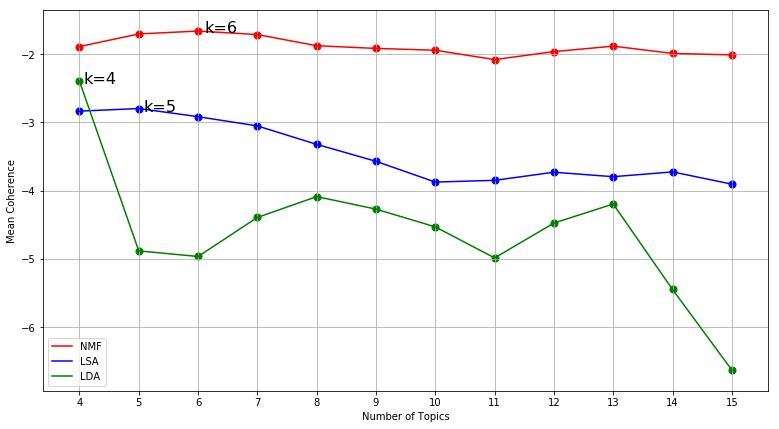

In [26]:
plot_coherences(k_values_nmf_umass, k_values_lsa_umass, k_values_lda_umass,
                coherences_nmf_umass, coherences_lsa_umass, coherences_lda_umass)

NMF лучше по всем метрикам

In [27]:
def all_descriptors(k, H, terms):
    descriptors = []
    for topic_index in range(k):
        descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
        str_descriptor = ", ".join( descriptors[topic_index] )
        print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

In [28]:
k = 14   # 14 is best_k for nmf_tc_w2v
H = topic_models_NMF[k-kmin][2]  

all_descriptors(k, H, terms)

Topic 01: com, netcom, hp, article, writes, ibm, sun, car, organization, subject
Topic 02: god, jesus, people, bible, christian, christians, believe, faith, christ, think
Topic 03: edu, university, posting, host, nntp, cc, cs, organization, subject, lines
Topic 04: windows, window, file, dos, files, program, card, graphics, help, mouse
Topic 05: pitt, geb, gordon, banks, cs, cadre, dsl, n3jxp, chastity, shameful
Topic 06: key, clipper, chip, encryption, keys, escrow, government, algorithm, security, crypto
Topic 07: ca, team, game, hockey, players, games, play, nhl, season, toronto
Topic 08: nasa, gov, space, larc, jpl, henry, jsc, moon, alaska, gsfc
Topic 09: armenian, turkish, armenians, armenia, argic, serdar, turks, turkey, people, genocide
Topic 10: scsi, drive, ide, controller, drives, disk, hard, bus, mac, card
Topic 11: uk, ac, __, dcs, university, cam, ed, ___, 44, subject
Topic 12: keith, caltech, sgi, livesey, morality, wpd, cco, solntze, jon, objective
Topic 13: israel, isr

In [29]:
k = 13   # 13 is best_k for nmf_uci
H = topic_models_NMF[k-kmin][2]  

all_descriptors(k, H, terms)

Topic 01: com, netcom, hp, article, writes, ibm, car, sun, organization, subject
Topic 02: god, jesus, people, bible, christian, christians, believe, faith, christ, think
Topic 03: edu, university, posting, host, nntp, cc, state, organization, article, cs
Topic 04: windows, window, file, dos, files, program, card, graphics, help, thanks
Topic 05: pitt, geb, gordon, banks, cs, cadre, dsl, n3jxp, chastity, shameful
Topic 06: key, clipper, chip, encryption, keys, escrow, government, algorithm, security, crypto
Topic 07: ca, team, game, hockey, players, games, play, nhl, season, toronto
Topic 08: nasa, gov, space, larc, jpl, henry, moon, jsc, alaska, gsfc
Topic 09: armenian, turkish, armenians, armenia, argic, serdar, turks, turkey, people, genocide
Topic 10: scsi, drive, ide, controller, drives, disk, hard, bus, mac, card
Topic 11: uk, ac, __, dcs, university, cam, ed, ___, 44, subject
Topic 12: keith, caltech, sgi, livesey, morality, wpd, cco, solntze, jon, objective
Topic 13: israel, is

In [30]:
k = 6   # 6 is best_k for nmf_umass
H = topic_models_NMF[k-kmin][2]  

all_descriptors(k, H, terms)

Topic 01: com, article, writes, netcom, hp, nasa, ibm, car, organization, sun
Topic 02: god, people, jesus, think, believe, bible, christian, christians, life, faith
Topic 03: edu, university, posting, host, nntp, article, cs, organization, writes, subject
Topic 04: windows, drive, card, dos, uk, scsi, file, ac, thanks, window
Topic 05: pitt, geb, gordon, banks, cs, cadre, dsl, n3jxp, chastity, shameful
Topic 06: key, clipper, chip, encryption, keys, escrow, government, security, algorithm, crypto


#### Я выбираю NMF TC, k = 14

In [31]:
from sklearn.neighbors import NearestNeighbors

In [42]:
class NewsRecommender:
    def __init__(self):
        self.model = NMF(init="nndsvd", n_components=14, random_state=42)
        self.nneighbors = NearestNeighbors(metric='cosine')
        custom_stop_words = []
        with open( "stopwords.txt", "r" ) as f:
            for line in f.readlines():
                custom_stop_words.append( line.strip().lower() )
        self.tfidf = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
        
    def train(self, texts):
        self.texts = [i.lower() for i in texts]
        A = self.tfidf.fit_transform(self.texts)
        W = self.model.fit_transform(A)
        self.nneighbors.fit(W)

    def recommend(self, text_sample, k):
        A = self.tfidf.transform([text_sample.lower()])
        W = self.model.transform(A)   
        idx = self.nneighbors.kneighbors(W, k, return_distance=False) 
        return [self.texts[i] for i in idx[0]]

In [43]:
recom = NewsRecommender()
recom.train(data)

/home/katya/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [49]:
r_text = recom.recommend("Many of us have our special ways of dealing with our feelings and emotions. For instance, when 2017, scientists detected Einstein's gravitational waves from a new source - the collision of two dead stars, or neutron stars. The first direct detection of these waves was announced in 2016, when the Advanced LIGO laboratories described the warping of space from the merger of two distant black holes. The result was hailed as the starting point for a new branch of astronomy, using gravitational waves to collect data about distant phenomena.", 5)

/home/katya/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [52]:
for i in r_text:
    print(i[:1000], '\n---------------------------------------------------------------------------\n')

from: thomsonal@cpva.saic.com
subject: cosmos 2238: an eorsat
article-i.d.: cpva.15337.2bc16ada
organization: science applications int'l corp./san diego
lines: 48

>date: tue, 6 apr 1993 15:40:47 gmt

>i need as much information about cosmos 2238 and its rocket fragment (1993-
>018b) as possible. both its purpose, launch date, location, in short,
>everything! can you help?

>-tony ryan, "astronomy & space", new international magazine, available from:

------------------------------------------------------------------------------

ocean reconnaissance launch surprises west
space news, april 5-11, 1993, p.2
[excerpts]
     russia launched its first ocean reconnaissance satellite in 26 months 
march 30, confounding western analysts who had proclaimed the program dead. 
     the itar-tass news agency announced the launch of cosmos 2238 from 
plesetsk cosmodrome, but provided little description of the payload's mission. 
     however, based on the satellite's trajectory, western observers 
